<h1 align="center">Implementación de un Sistema de Recomendación de películas con Factorización Matricial</h1>

En este Notebook vamos a implementar y evaluar un **Sistema de Recomendación basado en Filtrado Colaborativo con Factorización Matricial** usando la base de datos de ``fc_model.parquet``

In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# Importacion de librerías
import pandas as pd
import numpy as np
import seaborn as sns
# Gestionar las rutas
import utils.paths as path

## 1. Lectura del Dataset (Entrenamiento y Test)

A continuación realizaremos la lectura de los datos del dataset que se constituye por las columnas ``score``, ``title``, ``userId``, ``movieId``y ``show_id``, donde estas dos últimas columnas implican lo mismo (son identificadores de cada item de video).

In [3]:
model_data_dir = path.make_dir_function("dataset")
fc_model_data_dir = model_data_dir("fc_model.parquet")

In [ ]:
# Carga de datos en Coolaboratory

# from google.colab import drive
# drive.mount('/content/drive')

# DIR_DATA = "/content/drive/MyDrive/pi/fc_model.parquet"
# df = pd.read_parquet(DIR_DATA)

Arrancamos abriendo el dataset ya modificado:

In [4]:
# Lectura del dataset
df = pd.read_parquet(fc_model_data_dir)
df.head()

,show_id,title,movieId,score,userId
0,as1,the grand seduction,as1,5.0,543
1,as1,the grand seduction,as1,3.0,595
2,as1,the grand seduction,as1,3.0,611
3,as1,the grand seduction,as1,3.5,2523
4,as1,the grand seduction,as1,4.0,3082


## 2. Exploración del Dataset

1. ¿Cuántos usuarios únicos hay?
2. ¿Cuántas películas calificó cada usuario?
3. ¿Cómo es la distribución de las calificaciones?¿Pueden concluir algo de ese gráfico?
4. ¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

In [5]:
# Las columnas show_id y movieId tienen los mismos datos. Eliminaremos show_id 
df = df.drop('show_id', axis=1)

In [6]:
# Maximos y mínimos de los datos del dataset
df.describe()

,score,userId
count,1.099563e+07,1.099563e+07
mean,3.533545e+00,8.998200e+04
std,1.060160e+00,8.686946e+04
min,5.000000e-01,1.000000e+00
25%,3.000000e+00,2.855700e+04
50%,3.500000e+00,5.684500e+04
75%,4.000000e+00,1.168760e+05
max,5.000000e+00,2.708960e+05


In [7]:
# Verificamos los tipos de datos del dataset
df.dtypes

title       object
movieId     object
score      float32
userId       int32
dtype: object

Uno de los desafíos que plantea este dataset es que es bastante "grande". Esto quiere decir que, si lo cargamos completo, ocupa bastante lugar en nuestra memoria RAM. Además, cada tarea puede llevar mucho tiempo de procesamiento. Entonces, es necesario plantear una estrategia para abordarlo. Existen varias posibilidades, sin embargo, lo más práctico es redefinir los tipos de datos para que ocupen la menor cantidad de espacio (bytes) en la memoria RAM con la ayuda de la librería Numpy.

NumPy tiene varios tipos de datos enteros y puntos flotantes que se pueden usar en los arreglos de NumPy. A continuación se presenta una lista de los tipos de enteros y puntos flotantes con sus respectivos intervalos de números que pueden almacenar:

``int8``: enteros con signo de 8 bits. Pueden almacenar números en el intervalo de -128 a 127.
``int16``: enteros con signo de 16 bits. Pueden almacenar números en el intervalo de -32768 a 32767.
``int32``: enteros con signo de 32 bits. Pueden almacenar números en el intervalo de -2147483648 a 2147483647.
``int64``: enteros con signo de 64 bits. Pueden almacenar números en el intervalo de -9223372036854775808 a 9223372036854775807.

``float16``: 16 bits de precisión. Rango de alrededor de -65500 a 65500, con una precisión de alrededor de 1 en 2000.
``float32``: 32 bits de precisión. Rango de alrededor de -3.4 x 10^38 a 3.4 x 10^38, con una precisión de alrededor de 1 en 10^7.
``float64``: 64 bits de precisión. Rango de alrededor de -1.8 x 10^308 a 1.8 x 10^308, con una precisión de alrededor de 1 en 10^16.
``float128``: 128 bits de precisión. Rango y precisión dependen del hardware y la implementación, pero generalmente son mucho mayores que los de ``float64``.

En este caso ya están correctamente definidos los tipos de datos numéricos.

### 2.1. 1. ¿Cuántos usuarios y películas únicos hay?

In [10]:
# Usuarios únicos
unique_users = len(df['userId'].unique())
unique_movies = len(df['movieId'].unique())
print(f'La cantidad de usuarios únicos es {unique_users} y la cantidad de peliculas únicas es de {unique_movies}')

La cantidad de usuarios únicos es 115077 y la cantidad de peliculas únicas es de 22998


### 2.2. ¿Cuántas películas calificó cada usuario?

In [40]:
# Cantidad de películas que calificó cada usuario
movie_counts = df.groupby('userId')['movieId'].count().reset_index()
movie_counts = movie_counts.rename(columns={'movieId':'count'})

top_5_most = movie_counts.sort_values(by="count", ascending=False).reset_index(drop=True).head(5)
top_5_fewest = movie_counts.sort_values(by="count", ascending=True).reset_index(drop=True).head(5)

top_5_most['porcWatched']= np.round(top_5_most['count']/df['movieId'].unique().shape[0]*100, 1)
top_5_fewest['porcWatched']= np.round(top_5_fewest['count']/df['movieId'].unique().shape[0]*100, 1)

print(f'Top 5 de los usuarios que mayor cantidad de peliculas calificaron:\n{top_5_most}\n')
print(f'Top 5 de los usuarios que menor cantidad de peliculas calificaron:\n{top_5_fewest}')

Top 5 de los usuarios que mayor cantidad de peliculas calificaron:
   userId  count  porcWatched
0   45811  16965         73.8
1    8659   8759         38.1
2  270123   7458         32.4
3   70648   5211         22.7
4   24025   4861         21.1

Top 5 de los usuarios que menor cantidad de peliculas calificaron:
   userId  count  porcWatched
0  114673      1          0.0
1   48563      1          0.0
2  263267      1          0.0
3   61916      1          0.0
4  263243      1          0.0


* El usuario con el identificador ``userId`` de ``45811`` realizó ``16965`` calificaciones de películas que representa un **73.8%** del total de películas que existen en la base de datos de las diferentes plataformas, casi el doble del segundo usuario que tuvo la oprtunidad de calificar ``8759`` películas.
* No existe usuario alguno que no haya realizado una calificación al menos a una película, es decir, todos los usuarios vieron al menos una película en las diferentes plataformas.

### 2.3. ¿Cuántas películas calificó cada usuario?

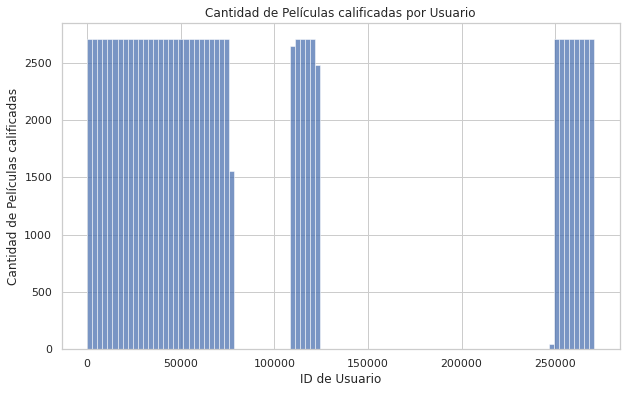

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set(style="whitegrid")

# crear DataFrame agrupado y ordenado por la cantidad de películas por usuario
movie_counts = df[['userId','movieId']].groupby('userId').count().reset_index()
movie_counts = movie_counts.rename(columns={'movieId':'count'})

# Trazando la gráfica
plt.figure(figsize=(10,6))
ax = sns.histplot(data=movie_counts, x="userId", bins=100, kde=False, color="b")
ax.set(xlabel="ID de Usuario", ylabel="Cantidad de Películas calificadas")
ax.set_title("Cantidad de Películas calificadas por Usuario")

plt.show()

### 2.4. ¿Cuál es la película con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

In [70]:
most_watched_movies = df.groupby("movieId")['userId'].count().reset_index().rename(columns={'userId':'count'})
top_5_most_watched_movies = most_watched_movies.sort_values(by="count", ascending=False).reset_index(drop=True).iloc[:5,:]
top_5_most_watched_movies['title'] = top_5_most_watched_movies['movieId'].apply(lambda x: df[df['movieId']==x]['title'].values[0].title())

top_5_fewest_watched_movies = most_watched_movies.sort_values(by="count", ascending=True).reset_index(drop=True).iloc[:5,:]
top_5_fewest_watched_movies['title'] = top_5_fewest_watched_movies['movieId'].apply(lambda x: df[df['movieId']==x]['title'].values[0].title())

print(f'Top 5 de las peliculas que mayor cantidad de calificaciones recibieron:\n{top_5_most_watched_movies}\n')
print(f'Top 5 de las peliculas que menor cantidad de calificaciones recibieron:\n{top_5_fewest_watched_movies}')

Top 5 de las peliculas que mayor cantidad de calificaciones recibieron:
  movieId  count                             title
0  as4197    573                 From Other Worlds
1  as9065    560                  The Organization
2  ns7279    558  Leapfrog: Sing-Along, Read-Along
3   as848    557                         Superbook
4  hs2360    555                          Dietland

Top 5 de las peliculas que menor cantidad de calificaciones recibieron:
  movieId  count                                     title
0  as4940    394                          Mitzi (Nbc 1968)
1  ns2144    398  Rob Schneider: Asian Momma, Mexican Kids
2  hs1711    400                                I Am Alone
3  ns6535    402               Cop And A Half: New Recruit
4   hs599    403                                      Dave


Las cinco películas que ricibieron mayor cantidad de calificaciones son ``From Other Worlds, The Organization``, ``Leapfrog: Sing-Along, Read-Along``, ``Superbook``, ``Dietland`` en orden descendente. Y los menos calificados son ``Mitzi (Nbc 1968)``, ``Rob Schneider: Asian Momma, Mexican Kids``, ``I Am Alone``, ``Cop And A Half: New Recruit`` y ``Dave``, en orden ascendente.

### 2.5. ¿Cómo es la distribución de las calificaciones?

In [75]:
import matplotlib.pyplot as plt

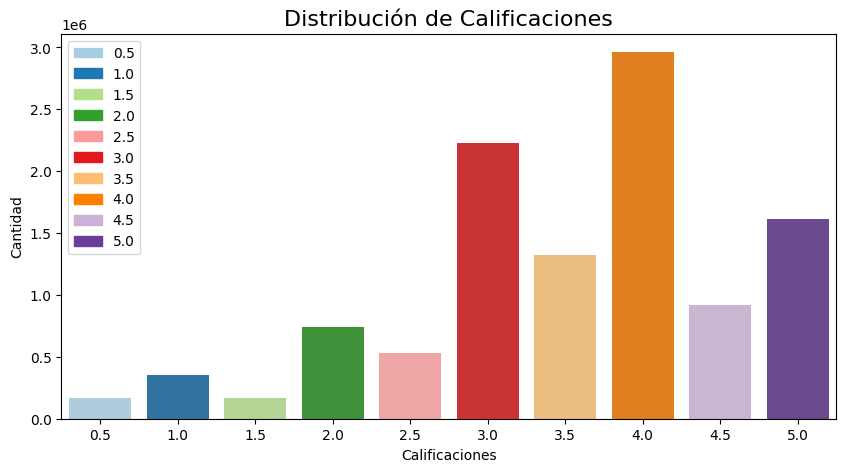

In [76]:
# Agrupar las puntuaciones y contar las ocurrencias
count_scores = df.groupby('score')['movieId'].count().reset_index()
count_scores = count_scores.rename(columns={'movieId': 'count'})

# Crear una paleta de colores
colors = sns.color_palette('Paired', len(count_scores)) #  "Dark2", "Set1", "Paired", "tab10"

# Definir el tamaño de la gráfica
plt.figure(figsize=(10,5))

# Crear un gráfico de barras utilizando Seaborn
ax = sns.barplot(data=count_scores, x='score', y='count', palette=colors)

# Agregar etiquetas y título
ax.set(xlabel='Calificaciones', ylabel='Cantidad')
ax.set_title('Distribución de Calificaciones', fontsize=16)

# Crear la leyenda
legend_labels = count_scores['score']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(legend_labels))]
plt.legend(handles, legend_labels)
plt.grid(False)
# Mostrar la gráfica de barras
plt.show()

La mayor cantidad de peliculas tienen un score de **4.0** y **3.0**, es decir, muchas personas han calificado con esta puntuaciones a las peliculas que han visto y muy probablemente recomendarían a otros usuarios. Las calificaciones de **0.5**, **1.5** y **1.0** tienen menor presencia, lo que implica menor presencia de pelicúlas que no les gustan o recomendarían los usuarios a otros.

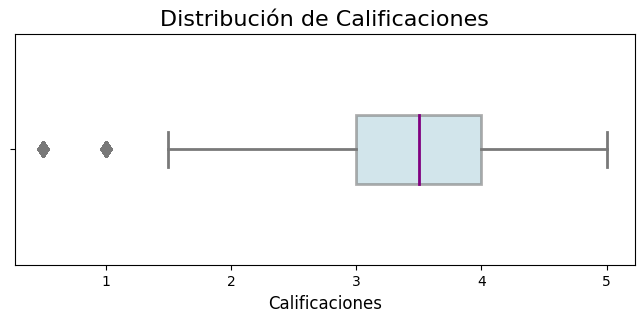

In [77]:
# Crear una gráfica de caja utilizando Seaborn
plt.figure(figsize=(8,3))
ax = sns.boxplot(data=df, x='score', color='lightblue', fliersize=8, linewidth=2, width=0.3, medianprops={'color': 'purple', 'linewidth': 2}, boxprops=dict(alpha=.6))
# Agregar etiquetas y título
ax.set_xlabel('Calificaciones', fontsize=12)
ax.set_title('Distribución de Calificaciones', fontsize=16)
# Mostrar la gráfica de caja
plt.show()

<h3>Validación cruzada de un modelo SVD simple</h3>

## Entrenamiento

Para entrenar nuestro modelo de sistema de recomendación vamos a usar la biblioteca [Surprise](https://surprise.readthedocs.io/en/stable/getting_started.html).

### 3.1 Dataset y Train/test split

Primero, llevamos el dataset al formato que le gusta a la biblioteca. ¿En qué orden tienen que estar los atributos?. Investigar qué hace la clase `Reader` y cuáles son sus parámetros.

In [15]:
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

Instanciamos la clase ``Reader()`` y definimos la escala de ``rating`` o ``score`` con loa valores extremos de esta variable.

In [16]:
reader = Reader(rating_scale=(df['score'].min(), df['score'].max()))

Luego, creamos el `Dataset` de Surprise usando `Dataset.load_from_df`

In [17]:
data = Dataset.load_from_df(df[['userId', 'movieId', 'score']], reader)

Separación de la data con ``tran_test_split`` considerando un 25% de la data de test.

In [18]:
trainset, testset = train_test_split(data, test_size=.25)

### 3.2 Entrenamiento

Vamos a entrenar un algoritmo SVD. Explorar sus parámetros y su funcionamiento.

El algoritmo SVD representará la matriz de calificación o score como un producto de matrices que representan los factores de cada video y los factores del usuario, respectivamente. Por supuesto, esta es una explicación muy breve del algoritmo SVD sin todos los detalles matemáticos, pero si desea una explicación más detallada de este algoritmo, debe consultar las notas de clase de Stanford CS 246 .

En el siguiente código, se realiza una validación cruzada de un modelo SVD utilizando una validación cruzada triple.

In [19]:
from surprise import SVD
from surprise.model_selection import cross_validate

In [20]:
svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9744  0.9748  0.9750  0.9747  0.0002  
MAE (testset)     0.7587  0.7591  0.7592  0.7590  0.0002  
Fit time          128.96  136.57  134.15  133.23  3.17    
Test time         103.52  92.19   106.05  100.59  6.03    


{'test_rmse': array([0.97438443, 0.97476899, 0.97495398]),
 'test_mae': array([0.75872981, 0.75909245, 0.75922956]),
 'fit_time': (128.9610402584076, 136.56857419013977, 134.150723695755),
 'test_time': (103.52426958084106, 92.18984127044678, 106.04711866378784)}

In [21]:
cv_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9751  0.9740  0.9750  0.9747  0.0005  
MAE (testset)     0.7594  0.7586  0.7591  0.7590  0.0003  
Fit time          161.39  157.09  134.59  151.02  11.75   
Test time         101.80  100.35  100.97  101.04  0.59    


<h2>Entrenamiento del modelo SVD</h2>

In [22]:
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


<h2>Generación de predicciones de calificación/score</h2>

Ahora que tenemos un modelo **SVD** entrenado, podemos usarlo para predecir la calificación que un usuario asignaría a una película dado un ID para el **usuario** (``uid``) y un ID para la **película/serie** (``iid``). El siguiente código demuestra cómo hacer esto con el método de predicción. De forma específica, para predecir un score/calificación para un usuario y una película en particular, usamos la función `predict`.

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

In [23]:
predictions = svd.test(testset)

In [24]:
# Exploremos las característica de `predictions` y alguno de sus elementos
predictions[1]

Prediction(uid=266199, iid='ns1502', r_ui=4.5, est=3.23750891776538, details={'was_impossible': False})

In [25]:
# uid: Usuario
# iid: Película/Serie
svd.predict(uid=543, iid="as1")

Prediction(uid=543, iid='as1', r_ui=None, est=3.3612860110237603, details={'was_impossible': False})

Guardamos el modelo desarrollado

In [28]:
import pickle

# model_dir = path.make_dir_function("models")
# fc_model_dir = model_dir("/content/drive/MyDrive/01-coolaboratory/fc_model_svd_v1.pkl")
fc_model_dir = "/content/drive/MyDrive/01-coolaboratory/fc_model_svd_v1.pkl"

with open(f'{fc_model_dir}', 'wb') as file:
    pickle.dump(svd, file)

In [88]:
# fc_model_dir = "/content/drive/MyDrive/01-coolaboratory/fc_model_svd_v1.pkl"
model_dir = path.make_dir_function("models")
fc_model_dir = model_dir("fc_model_svd_v1.pkl")

In [ ]:
import pickle
# Cargamos el modelo entrenado
with open(f'{fc_model_dir}', 'rb') as file:
    svd_loaded = pickle.load(file)

In [82]:
# Usar el modelo cargado para predecir la calificación de una película
user_id = 1
movie_id = 'as23'
predicted_rating = svd_loaded.predict(user_id, movie_id).est
predicted_rating

In [84]:
import gc
gc.collect()

3.8187708095543975

In [87]:
def generar_recomendacion(svd_model, user_id, df, top=4):
    """
    Genera recomendaciones para un usuario utilizando el modelo SVD

    Args:
    - svd_model: modelo SVD previamente entrenado
    - user_id: id del usuario para el cual se generarán las recomendaciones
    - top: cantidad de recomendaciones a generar (default=4)
    - df: DataFrame con columnas 'userId', 'movieId', 'score', 'title'

    Returns:
    - lista de títulos de películas recomendadas
    """

    # Obtener las películas que el usuario no ha visto aún
    movies_seen = set(df[df['userId'] == user_id]['movieId'])
    movies_all = set(df['movieId'])
    movies_unseen = list(movies_all - movies_seen)

    # Obtener las recomendaciones
    predicted_ratings = [svd_model.predict(user_id, movie_id).est for movie_id in movies_unseen]

    # Ordenar las películas según su predicción de rating
    movie_rating = list(zip(movies_unseen, predicted_ratings))
    movie_rating.sort(key=lambda x: x[1], reverse=True)

    # Obtener los títulos de las películas recomendadas
    recommended_movies = movie_rating[:top]
    recommended_titles = [df[df['movieId'] == movie_id]['title'].iloc[0] for movie_id, _ in recommended_movies]

    return {
        "recomended_movies": recommended_titles,
        "user_id": user_id,
        "top": 3 
    }